# Criterion for convergence in backward error after fault

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from sys import stdout
import math


## Import modules

In [3]:
from Experiment import *
from Parameters import *
from Fault import *
from Algorithm import *
from Utils import *

## Algorithm initialization

In [4]:
import gmres
import gmres_display

### algorithm parameters

In [5]:
# parameters that won't change during the whole experiment
epsilon = 1.e-12

algorithm_parameters = Parameters()
algorithm_parameters["orthMethod"] = gmres.modified_gramschmidt
algorithm_parameters["dtype"] = 'd'
algorithm_parameters["vulnerable"] = True
algorithm_parameters["save_data"] = {"iteration_count",
                                     "residual",
                                     "residuals",
                                     "true_residual",
                                     "true_residuals",
                                     "orthogonality",
                                     #"arnoldi",
                                     "faults",
                                     #"H",
                                     "V",
                                     "y",
                                     "checksum",
                                     "threshold",
                                     "criteria",
                                     "delta"
                                    }

### implementation

In [6]:
def implementation(self, input, algorithm_parameters, experiment_parameters):
    gmres.implementation(self, input, algorithm_parameters, experiment_parameters)

In [7]:
gmres_algorithm = Algorithm(algorithm_parameters, implementation)

## Experiment setup

## Load input

In [8]:
input = load_mat("./gre_216a.mat")
A = input["A"]
inputs = [input]
n = A.shape[0]

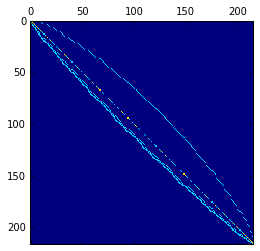

In [9]:
plt.matshow(A)

## Experiment initialization

### Experiment parameters

In [10]:
# Parameters that may change during the experiment
# Experiment parameters override Algorithm parameters
experiment_parameters = Parameters()

experiment_parameters["vulnerable"] = False
experiment_parameters["tol"] = 0
experiment_parameters["m"] = n
experiment_parameters["iterMax"] = n

In [11]:
F = Experiment(experiment_parameters, gmres_algorithm)
F.set_inputs(inputs)

## Run experiment

In [12]:
F.run(show_progress=True, n=1)

Complete ! 


In [13]:
minimum = min(filter(lambda d: d[1] < epsilon, enumerate(F.get_data("true_residuals")[0])),
                    key=lambda d: d[0])
print minimum
min_iteration = minimum[0]

(152, 4.6346312283642976e-13)


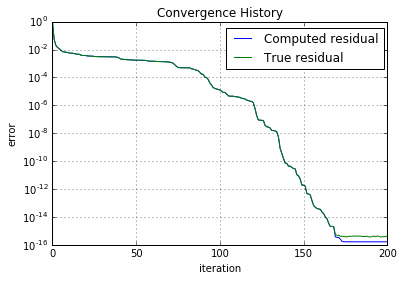

In [14]:
gmres_display.convergence_history(F.get_data()[0], xlim = (0, 200), ylim = (1.e-16, 1))

## Effect of faults in GMRES

### Experiment parameters

In [15]:
# Parameters that may change during the experiment
experiment_parameters = Parameters()

experiment_parameters["vulnerable"] = True
fault_parameters = {}
fault_parameters["fault_callback"] = lambda fault: (stdout.write(" %s " % str(fault)))
fault_parameters["register"] = "right"
fault_parameters["vulnerable"] = True
fault_parameters["vulnerable_bits"] = [int(np.random.rand() * 32)+32]
fault_parameters["fault_indices"] = {"i": int(np.random.rand()*n), 
                                     "j":0, 
                                     "k":int(np.random.rand()*n)}
fault_parameters["timer"] = int(np.random.rand() * 152)
experiment_parameters["fault_parameters"] = fault_parameters


#### Implementation (gmres)

In [16]:
def implementation(self, input, algorithm_parameters, experiment_parameters):
    gmres.implementation(self, input, algorithm_parameters, experiment_parameters)

In [17]:
gmres_algorithm = Algorithm(algorithm_parameters, implementation)

In [18]:
E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=1)

Complete ! 


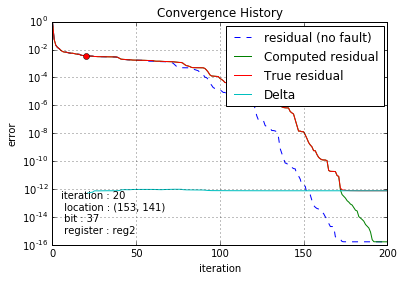

In [19]:
gmres_display.convergence_history(E.get_data()[0], data_no_fault = F.get_data()[0], fault = True, delta = True,  xlim = (0, 200), ylim = (1.e-16, 1),xytext = (5, 1.e-16), bbox_to_anchor=(0.5, 0.8))

### Parameters influence

In [20]:
def experiment_parameters_generator(vulnerable = True,
                                    tol = 0,
                                    bits = [40], 
                                    iterations = [80], 
                                    registers = ["left"], 
                                    indices = [{"i":29, "j":0, "k":56}],
                                    fault_callback = lambda fault: (stdout.write(" %s " % str(fault)))
                                   ):
    parameters = Parameters()
    parameters["vulnerable"] = vulnerable
    parameters["tol"] = tol
    fault_parameters = {}
    fault_parameters["fault_callback"] = fault_callback
    fault_parameters["vulnerable"] = vulnerable
    while (True):

        parameters["fault_parameters"] = fault_parameters

        for bit in bits:
            for iteration in iterations:
                for reg in registers:
                    for indice in indices:
                        fault_parameters["vulnerable_bits"] = [bit]
                        fault_parameters["timer"] = iteration
                        fault_parameters["register"] = reg
                        fault_parameters["fault_indices"] = indice
                        yield parameters

#### Bit flipped

In [21]:


experiment_parameters = experiment_parameters_generator(bits = [60, 40, 20])

E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=3)

Complete ! 


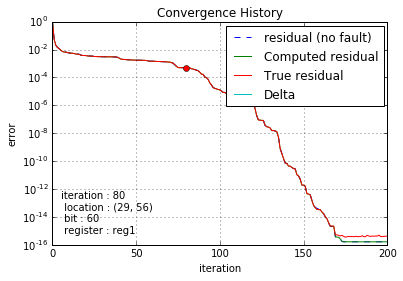

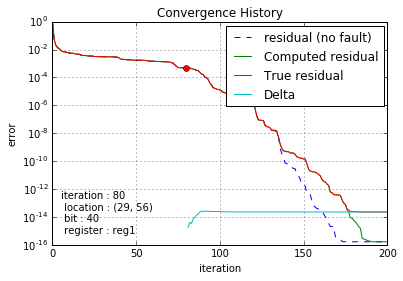

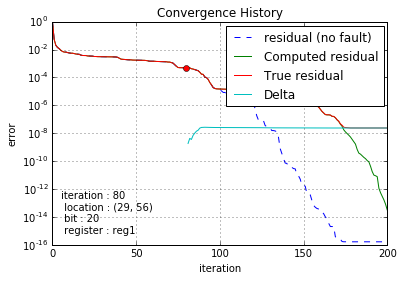

In [22]:
for data in E.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], fault = True, delta = True, xlim = (0, 200), ylim = (1.e-16, 1), xytext = (5, 1.e-16), bbox_to_anchor=(0.5, 0.8))
    plt.show()

#### Iteration

In [23]:
experiment_parameters = experiment_parameters_generator(iterations = [0, 60, 120])

E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=3)

Complete ! 


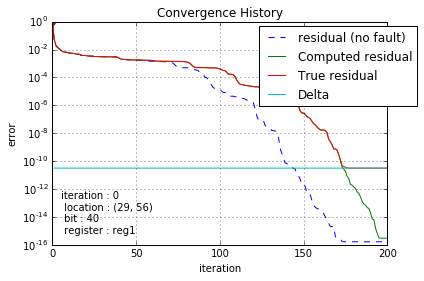

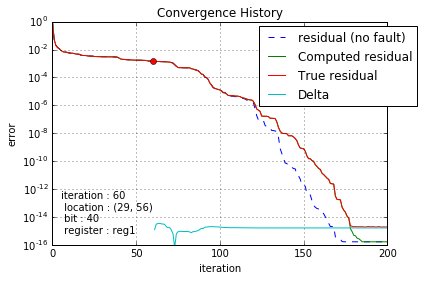

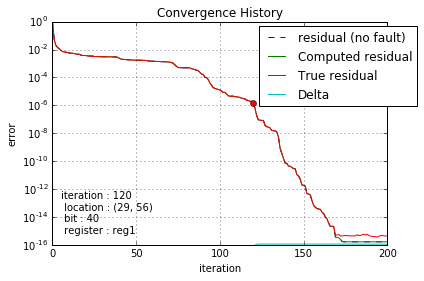

In [24]:
for data in E.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], fault = True, delta = True, xlim = (0, 200), ylim = (1.e-16, 1), xytext = (5, 1.e-16), bbox_to_anchor=(0.6, 0.8))
    plt.show()

#### register

In [25]:
experiment_parameters = experiment_parameters_generator(registers = ["left", "right", "middle"])

E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=3)

Complete ! 


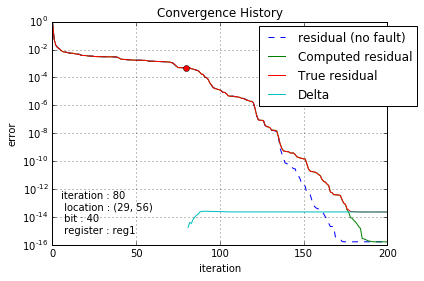

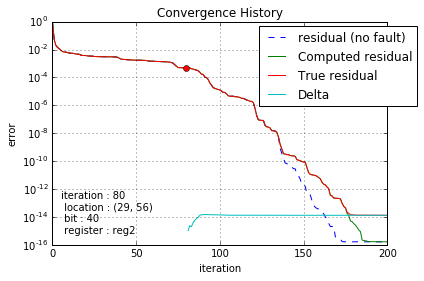

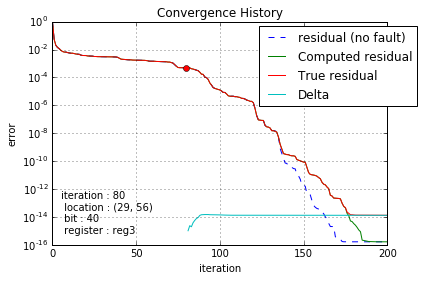

In [26]:
for data in E.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], fault = True, delta = True, xlim = (0, 200), ylim = (1.e-16, 1), xytext = (5, 1.e-16), bbox_to_anchor=(0.6, 0.8))
    plt.show()

#### location

In [27]:
experiment_parameters = experiment_parameters_generator(indices = [{"i": int(np.random.rand()*n), 
                                                                    "j":0, 
                                                                    "k":int(np.random.rand()*n)} for i in xrange(3)]  
)

E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=3)

Complete ! 


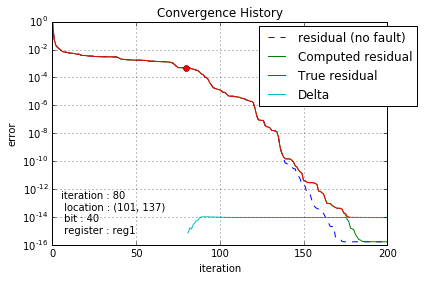

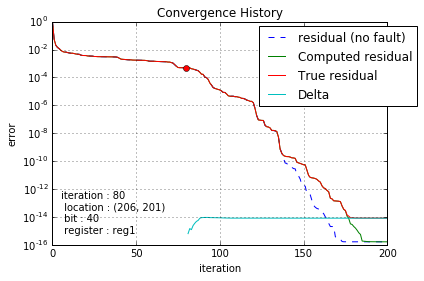

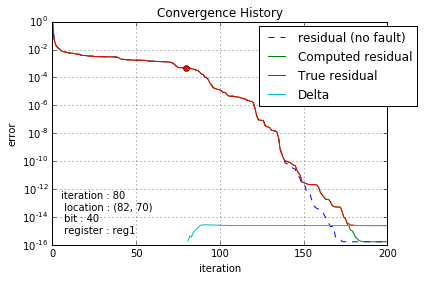

In [28]:
for data in E.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], fault = True, delta = True, xlim = (0, 200), ylim = (1.e-16, 1), xytext = (5, 1.e-16), bbox_to_anchor=(0.6, 0.8))
    plt.show()

## Quantitative study

In [29]:
step_ite = 1
step_bit = 1


experiment_parameters = experiment_parameters_generator(bits = np.arange(63, 0, -step_bit),
                                                       iterations = np.arange(0, 153, step_ite))

E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=int(math.ceil(153./step_ite)) * int(math.ceil(64./step_bit)))

96 %  {'register_before': 0.25, 'loc': {'i': 29, 'k': 56, 'j': 0}, 'value_before': -0.0047835513561112018, 'register': 'left', 'timer': 68, 'register_after': 1.8645851828000517e-155, 'bit': 2, 'value_after': -0.014871502172941684}  {'register_before': 0.25, 'loc': {'i': 29, 'k': 56, 'j': 0}, 'value_before': -0.047003473004225041, 'register': 'left', 'timer': 69, 'register_after': 1.8645851828000517e-155, 'bit': 2, 'value_after': -0.035641918661090136}  {'register_before': 0.25, 'loc': {'i': 29, 'k': 56, 'j': 0}, 'value_before': -0.013308506825468899, 'register': 'left', 'timer': 70, 'register_after': 1.8645851828000517e-155, 'bit': 2, 'value_after': -0.0091271369579881394}  {'register_before': 0.25, 'loc': {'i': 29, 'k': 56, 'j': 0}, 'value_before': -0.040870206851947644, 'register': 'left', 'timer': 71, 'register_after': 1.8645851828000517e-155, 'bit': 2, 'value_after': -0.020536867889271206}  {'register_before': 0.25, 'loc': {'i': 29, 'k': 56, 'j': 0}, 'value_before': -0.082389755462

gmres.py:120: RuntimeWarning: overflow encountered in double_scalars
  mu = np.sqrt(H[i, i]**2 + H[i+1, i]**2)
gmres.py:122: RuntimeWarning: invalid value encountered in double_scalars
  sn_i = -H[i+1, i] / mu


Complete ! 


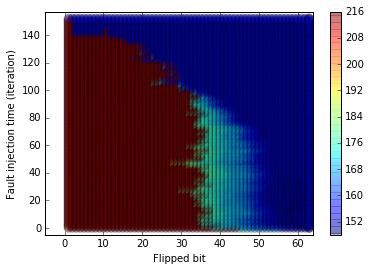

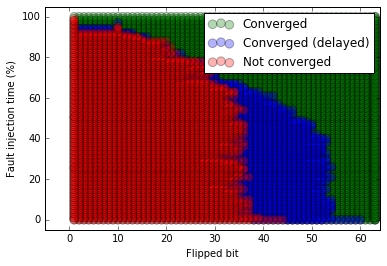

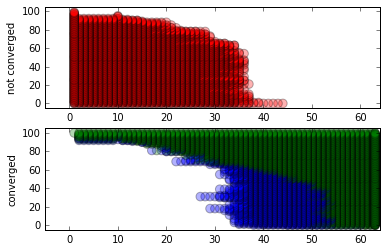

In [30]:
def has_converged(data, epsilon = 1.e-12):
    return len(filter (lambda d: d[0] < epsilon and d[1] < epsilon, zip(data["true_residuals"], data["residuals"]))) > 0

def when_has_converged(data, epsilon = 1.e-12):
    iteration_residual = filter (lambda d: d[1][0] < epsilon and d[1][1] < epsilon, 
                                 enumerate(zip(data["true_residuals"], data["residuals"])))
    if iteration_residual:
        return min(iteration_residual, key=lambda d:d[0])[0]
    else:
        return None
    
min_iteration = when_has_converged(F.get_data()[0])

def scatter_bit_injection(data, min_iteration = None,
                          convergence = None, delay = None, 
                          color = 'r', marker = 'o', area = 75, alpha = 0.3,
                          xlabel = "Flipped bit", ylabel="Fault injection time (%)",
                          xlim = [-5, 64], ylim = [-5, 105],
                          epsilon = 1.e-12):
    if convergence != None:
        if convergence:
            data = filter(lambda d: has_converged(d, epsilon), data)
            if delay != None :
                if not min_iteration:
                        print "min_iteration should be set"
                        return
                if delay:
                    data = filter(lambda d: when_has_converged(d, epsilon) > min_iteration, data)
                else:
                    data = filter(lambda d: when_has_converged(d, epsilon) <= min_iteration, data)
        else:
            data = filter(lambda d: not has_converged(d, epsilon), data)
    
    X = map(lambda f: f["faults"][0]["bit"], data)
    if min_iteration:
        Y = map(lambda f: (100*f["faults"][0]["timer"]) / min_iteration, data)
    else:
        Y = map(lambda f: (f["faults"][0]["timer"]), data)
    C = []
    
    if hasattr(color, '__call__'):
        C = map(color, data)
    
    S = []
    if hasattr(area, '__call__'):
        S = map(area, data)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    return plt.scatter(X, Y, marker=marker, c=C, s=S, alpha = alpha)


scatter_bit_injection(E.get_data(), 
                      color = lambda d: when_has_converged(d, epsilon) if has_converged(d, epsilon) else 216,
                      area = lambda d: 75,
                      ylabel = "Fault injection time (iteration)",
                      ylim = [-5, min_iteration+5])
plt.colorbar()
plt.show()

converged = scatter_bit_injection(E.get_data(), min_iteration, 
                      convergence = True,
                      color = lambda d: "red" if not has_converged(d, epsilon) else "blue" if when_has_converged(d, epsilon) > min_iteration else "green",
                      area = lambda d: 75)

delayed = scatter_bit_injection(E.get_data(), min_iteration, 
                      convergence = True, delay = True,
                      color = lambda d: "red" if not has_converged(d, epsilon) else "blue" if when_has_converged(d, epsilon) > min_iteration else "green",
                      area = lambda d: 75)

not_converged = scatter_bit_injection(E.get_data(), min_iteration, 
                      convergence = False,
                      color = lambda d: "red" if not has_converged(d, epsilon) else "blue" if when_has_converged(d, epsilon) > min_iteration else "green",
                      area = lambda d: 75)

plt.legend((converged, delayed, not_converged),
           ('Converged', 'Converged (delayed)', 'Not converged'))

plt.show()


plt.subplot(2, 1, 1)
scatter_bit_injection(E.get_data(), min_iteration, 
                      convergence = False,
                      color = lambda d: "red" if not has_converged(d, epsilon) else "blue" if when_has_converged(d, epsilon) > min_iteration else "green",
                      area = lambda d: 75,
                      xlabel = None, ylabel = "not converged")

plt.subplot(2, 1, 2)
scatter_bit_injection(E.get_data(), min_iteration, 
                      convergence = True,
                      color = lambda d: "red" if not has_converged(d, epsilon) else "blue" if when_has_converged(d, epsilon) > min_iteration else "green",
                      area = lambda d: 75,
                      xlabel = None, ylabel = "converged")

   
#plt.xlabel("flipped bit")
#plt.ylabel("Fault injection time (%)")       
    
#scatter_bit_injection(E.get_data(), min_iteration)

#plt.legend((conv, conv_delay, no_conv),
#           ('Convergence', 'Convergence (no delay)', 'No convergence'),
#           scatterpoints=1,
#           loc='upper right',
#           ncol=1,
#           fontsize=8)




## Quantitative results

In [31]:
def experiment_parameters_generator_random(vulnerable = True,
                                    tol = 0,
                                    m = 100,
                                    fault_callback = lambda fault: (stdout.write(" %s " % str(fault)))
                                   ):
    import random
    
    parameters = Parameters()
    parameters["vulnerable"] = vulnerable
    parameters["tol"] = tol
    fault_parameters = {}
    fault_parameters["fault_callback"] = fault_callback
    fault_parameters["vulnerable"] = vulnerable
            
    parameters["fault_parameters"] = fault_parameters
        
    while (True):
        fault_parameters["timer"] = random.choice([i for i in xrange(m)])
        yield parameters

mcca.mat
12 % 

gmres.py:184: RuntimeWarning: overflow encountered in double_scalars
  Ej = abs(error / v_min)


Complete ! 
bwm200.mat
 {'register_before': -2.8820776421180425, 'loc': {'i': 64, 'k': 63, 'j': 0}, 'value_before': 61.401967370677085, 'register': 'middle', 'timer': 101, 'register_after': 2.8820776421180425, 'bit': 0, 'value_after': 67.166122654913167} robot.mat
Complete ! 
ex1.mat
Complete ! 
gre_216a.mat
Complete ! 
arc130.mat
Complete ! 
sherman2.mat
 {'register_before': -0.0048932911636317585, 'loc': {'i': 908, 'k': 917, 'j': 0}, 'value_before': -3.2048642818792441, 'register': 'right', 'timer': 1, 'register_after': -0.004893261361309371, 'bit': 28, 'value_after': -3.2048642818791517} 

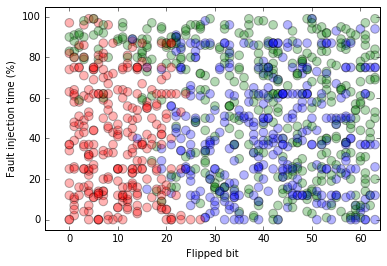

In [32]:
import os


for mat_file in os.listdir(os.getcwd()):
    if mat_file.endswith(".mat"): 
        print mat_file
        _inputs = [load_mat(mat_file)]
        _F = Experiment(Parameters({"tol":1.e-16}), gmres_algorithm)
        _F.set_inputs(_inputs)
        _F.run(n = 1)
        if has_converged(F.get_data()[0], epsilon = 1.e-8):
            min_iteration = when_has_converged(_F.get_data()[0], epsilon = 1.e-8)
            if min_iteration:
                _G = Experiment(experiment_parameters_generator_random(m=min_iteration, tol = 0), gmres_algorithm)
                _G.set_inputs(inputs)
                _G.run(show_progress=True, n=200)
                scatter_bit_injection(filter(lambda d: len(d["faults"]) > 0, _G.get_data()), min_iteration, 
                                  color = lambda d: "red" if not has_converged(d, epsilon = 1.e-8) else "blue" if when_has_converged(d, epsilon = 1.e-8) > min_iteration else "green",
                                  area = lambda d: 75, epsilon = epsilon)

## Fault detection

### Qualitative results

In [33]:
input = load_mat("./gre_216a.mat")
A = input["A"]
inputs = [input]
n = A.shape[0]

In [41]:
experiment_parameters = experiment_parameters_generator(bits = [40, 35, 30], tol = epsilon)

E = Experiment(experiment_parameters, gmres_algorithm)
E.set_inputs(inputs)
E.run(show_progress=True, n=3)

Complete ! 


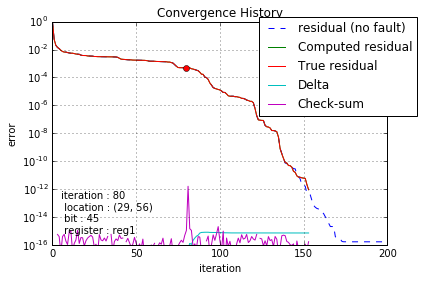

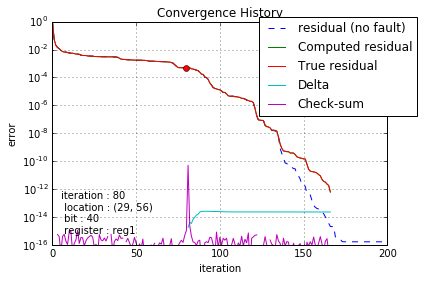

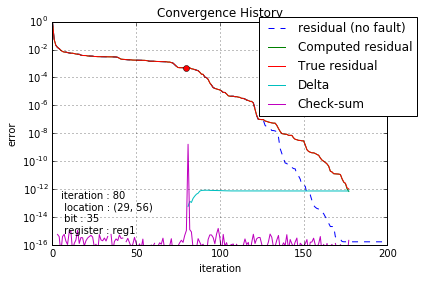

In [39]:
for data in E.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], fault = True, delta = True, checksum=True, xlim = (0, 200), ylim = (1.e-16, 1), xytext = (5, 1.e-16), bbox_to_anchor=(0.6, 0.8))
    plt.show()

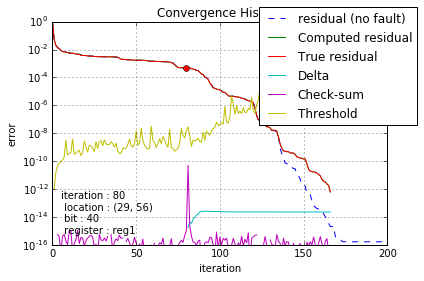

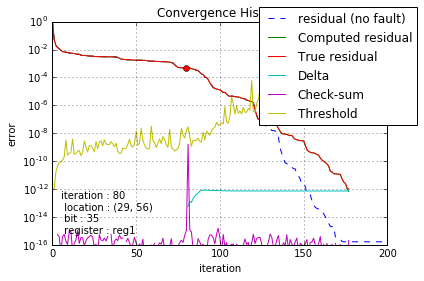

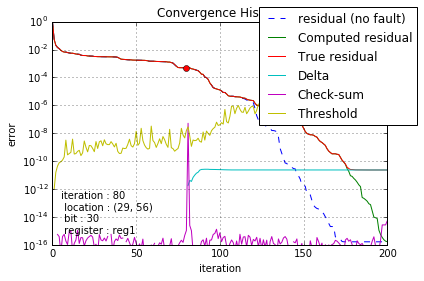

In [42]:
for data in E.get_data():
    gmres_display.convergence_history(data, data_no_fault = F.get_data()[0], fault = True, delta = True, checksum=True, threshold = True, xlim = (0, 200), ylim = (1.e-16, 1), xytext = (5, 1.e-16), bbox_to_anchor=(0.6, 0.8))
    plt.show()

In [45]:
def criterion(data, c = 0.25):
    return reduce(lambda d, e: d and (e[0] < e[1]), zip(data["checksum"], data["threshold"]))

In [47]:
print criterion(E.get_data()[0])
print criterion(E.get_data()[1])
print criterion(E.get_data()[2])

[ True]
[ True]
[False]
